## Gemma3 27B

* From Google
* Ranked #38 in OpenCompass multi-modal academic leaderboard for open-source models (https://rank.opencompass.org.cn/leaderboard-multimoal)

* There is randomness in its output that cannot be traced
* It is also relatively slow because of its size (27B)

In [2]:
# conda activate evalgemma

from transformers import pipeline
import torch

model_path = '/data/students/earl/llava-dissector/Gemma3-27b/gemma-3-27b-it'

pipe = pipeline(
    "image-text-to-text",
    model=model_path,
    #device="cuda",
    device_map="auto",
    #do_sample=False,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16
)

/data/students/earl/anaconda3/envs/evalgemma/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


Here are the bounding box coordinates for the helmet of the batter in the image:

*   **[0.338, 0.331, 0.386, 0.413]**
Bounding Boxes: [[0.338, 0.331, 0.386, 0.413]]


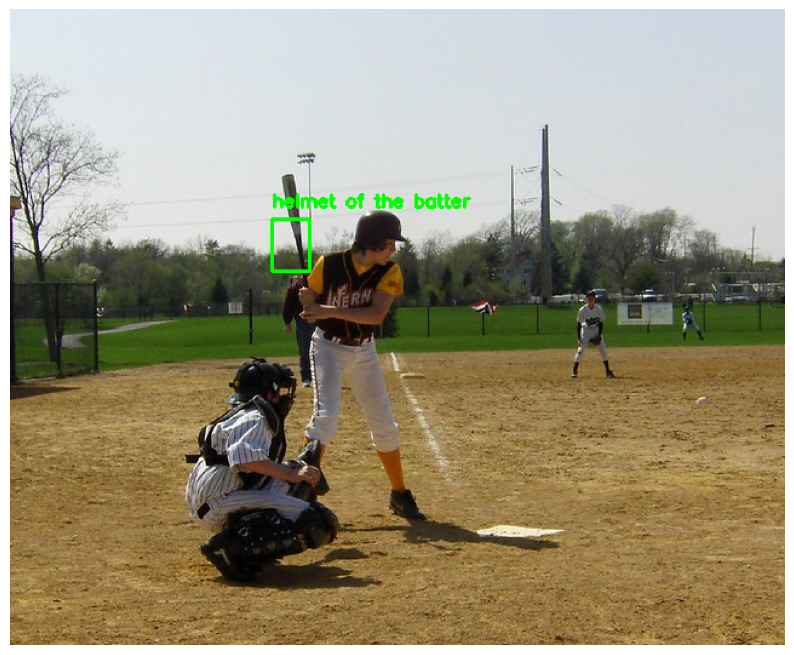

In [23]:
import cv2
import io
import re
import requests
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

cls = "helmet of the batter"
pipe.model.threshold = -1.5

image_path = url = "https://farm3.staticflickr.com/2402/2480652763_e6b62303ee_z.jpg"
text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2] of all instances of {cls} in the image.'
#text = f'Give the normalized bounding box coordinates in the format [x1, y1, x2, y2], wherein x1, y1, x2, y2 are values between 0 and 1 of all instances of {cls} in the image.'


messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are a helpful assistant that can see all the fine details in an image."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image", "url": url},
            {"type": "text", "text": text}
        ]
    }
]

output = pipe(text=messages, max_new_tokens=1024)
response = output[0]["generated_text"][-1]["content"]
print(response)


# regex the part of string to extract bounding boxes
pattern = r'(?:[\[\(]\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*,\s*([\d.]+)\s*[\]\)])|(?:<box>\s*([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s*</box>)'
matches = re.findall(pattern, response)
bounding_boxes = []
for match in matches:
    # Each match is a tuple of 8 elements, only 4 will be filled
    coords = [c for c in match if c != '']
    if len(coords) == 4:
        bounding_boxes.append([float(c) for c in coords])
print(f'Bounding Boxes: {bounding_boxes}')

# Visualize using cv2
# Load the original image for visualization
image_from_url = requests.get(url)
orig_img = Image.open(io.BytesIO(image_from_url.content)).convert('RGB')
img_cv = np.array(orig_img)  # HWC, RGB
for box in bounding_boxes:
    x1, y1, x2, y2 = box
    # convert these normalized coordinates to pixel values
    h, w, _ = img_cv.shape
    x1 = int(x1 * w)
    y1 = int(y1 * h)
    x2 = int(x2 * w)
    y2 = int(y2 * h)
    # Draw the bounding box and label on the image
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img_cv, cls, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(img_cv)
plt.axis('off')
plt.show() 
